In [1]:
# Packages
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

# Control Variates for a GARCH Model

## Table of contents

### I - Presentation of the ZV principle of the article, in a general case
### II - Implementation of a Random Walk Metropolis Sampler
### III - Use of Control Variates
### IV - Expansion to Higher Order Polynomials
### V - Bonus: Linear Regression Validity
### VI - Conclusion

## I - Presentation of the ZV principle of the article, in a general case

Existing MCMC methods are already used to estimate the expectation of a function $f(x)$ with respect to a probability density $\pi(x)$, not necessarily normalized. This expectation is expressed by the following quantity:
$$ \mu_f = \frac{\int f(x)\pi(x)dx}{\int \pi(x)dx} $$

In practice, MCMCs estimate $\mu_f$ by taking the average of the $f(x_i)$ where $x_i$ are samples from a Markov chain that has $\pi$ as its stationary measure. This gives the following estimator:
$$ \hat{\mu}_f = \frac{1}{N}\sum_{i=1}^{N}f(x_i) $$

The innovative idea of the first proposed article is to reduce the variance of the MCMC estimator, $\hat{\mu}_f$, by replacing $f$ with a new function $\tilde{f}$ that satisfies $\hat{\mu}_f = \hat{\mu}_{\tilde{f}}$ under the measure $\pi$, but with a smaller variance $\mathrm{Var}(\hat{\mu}_f) < \mathrm{Var}(\hat{\mu}_{\tilde{f}})$.

To achieve this, a control function $\psi$ and a well-chosen operator $H$ are used, which allow us to write:
$$ \tilde{f}(x)=f(x)+\frac{H\psi(x)}{\sqrt{\pi(x)}} $$
The idea is thus to choose the right $H$ and the right function $\psi$ according to the use cases. Our project aims to adapt this method for a GARCH model.

The second article demonstrates how the method presented in the first can be implemented using the ordinary least squares estimator. By using control variables as covariates and $f(x)$ as the explained variable, we can find the optimal coefficients of the control variables and, consequently, use them in $\tilde{f}(x)$. For the case of the first-order polynomial *(to be discussed in III (Question 2))*, $\tilde{f}(x)$ can be written: $f(x) + a^T z$ where $z$ is the vector of covariates, and $a$ are the coefficients calculated by an OLS regression of $f(x)$ on $-z$.

This article also presents certain Lasso methods (LSLasso and LSLasso(X) in particular) to handle the case of higher degree polynomials. Indeed, this allows reducing the computation time by retaining only the most useful control variables and then applying OLS regressions only with these retained control variables. *We will discuss more on Lasso methods in IV (Question 3).*


## II - Implementation of a Random Walk Metropolis Sampler

*Follow the guidelines given in that experiment to implement a random walk Metropolis sampler that targets the posterior distribution of a GARCH model. For the data, you can use simulated data at first, and then look at the same type of real data (log-returns computed from exchange rates) in a second time.*


### Presentation of the Random Walk Metropolis-Hastings Sampler

The Metropolis-Hastings algorithm is a technique from the family of Markov Chain Monte Carlo (MCMC) methods. It facilitates the generation of a series of random samples from a probability distribution that is typically challenging to sample from directly. These samples can then be employed to approximate the distribution itself or to calculate integrals like expected values.

More precisely, for a given probability distribution $\pi$ defined over a set $\Omega$, the Metropolis-Hastings algorithm establishes a Markov chain. This chain is characterized by having $\pi$ as its stationary distribution, thereby enabling random sampling of elements from $\Omega$ as per the distribution $\pi$.

A notable aspect of the Metropolis-Hastings algorithm is that it requires knowledge of the distribution $\pi$ only up to a multiplicative constant. This is particularly advantageous as it circumvents the need to calculate the often intractable partition function of $\pi$, making the method highly useful in statistical physics.

As discussed in courses such as *Introduction to Stochastic Processes* and *Simulation and Monte Carlo Methods*, the algorithm's utility shines when calculating expectations. For instance, if we need to approximate the expectation $$\mathbb{E}_{X \sim \pi}[f] = \int_E f(x) \pi(x) dx$$ (assuming this integral exists), traditional simulation of independent and identically distributed variables $X_i$ from distribution $\pi$ would typically employ the law of large numbers: $$\frac{1}{n}\sum_{i=1}^n X_i \xrightarrow{p.s.}\int_E f(x) \pi(x) dx$$

However, if $\pi$ is complex, simulating variables from $\pi$ directly might be prohibitively costly. The Metropolis-Hastings method offers an alternative by simulating a positive, recurrent, irreducible Markov chain $(X_n)$ that converges to $\pi$ as its limit law. **According to the ergodic theorem for Markov chains:**

**Given $(X_n)$, a positive recurrent irreducible Markov chain with limit law $\pi$, transition matrix $P$, and initial distribution $\mu$, for all functions $f$ with $\int |f| d\pi < \infty$, we have:**
$$\frac{1}{n}\sum_{i=1}^n f(X_i) \to \int f d\pi \quad \text{almost surely as } n \to \infty$$

The Metropolis and Metropolis-Hastings algorithms simulate a Markov chain with a $\pi$-reversible transition matrix $P$, hence having $\pi$ as its invariant distribution. The primary verification left is to ensure the irreducibility of the chain; if it is irreducible and admits an invariant probability, it is positively recurrent.

The algorithm proceeds as follows:

Given a set $E = \mathbb{Z}^d$ for $d \geq 1$, consider the Metropolis-Hastings algorithm which involves the following components:

- **State Space and Proposal Distribution**: Let $q$ be a symmetric probability measure from which we can simulate a random variable. This distribution $q$ is used to propose movements in the state space, facilitating the exploration of the distribution $\pi$.

- **Initialization**: Begin with a fixed initial state $X_0$ in $E$.

For each iteration $n$:

1. **Generate Proposal**: Draw a candidate step $Z_n \sim q$, which is independent of all previously simulated variables. This step suggests a new position relative to the current state $X_n$.

2. **Random Uniform Draw**: Simultaneously, draw a random number $U_n \sim \mathcal{U}([0,1])$, also independent of previous draws. This value is used to decide whether to accept the proposed move.

3. **Acceptance Criterion**:
   - Define the acceptance probability as:
     $$
     \alpha(X_n, X_n + Z_n) = \min\left(1, \frac{\pi(X_n + Z_n)}{\pi(X_n)}\right)
     $$
   - Update the chain according to the acceptance probability:
     $$
     \begin{cases}
     X_{n+1} = X_n + Z_n & \text{if } U_n \leq \alpha(X_n, X_n + Z_n) \\
     X_{n+1} = X_n & \text{otherwise}
     \end{cases}
     $$

3. **Repetition**: Repeat the above step for a large number of iterations to form a chain whose distribution converges to $\pi$.

Key Features:
- **Flexibility in Proposal Distribution**: The choice of $q$ significantly impacts the efficiency of the algorithm. Ideally, $q$ should resemble $\pi$ as closely as possible to maximize the acceptance rate.
- **Convergence Properties**: Under broad conditions, the Markov chain generated by the Metropolis-Hastings algorithm is ergodic, meaning that it converges to the stationary distribution $\pi$, regardless of the starting point.
- **Multiplicative Constant**: A practical advantage of Metropolis-Hastings is its reliance only on the ratio of probabilities, which means the algorithm does not require knowledge of the normalizing constant of $\pi$.


### The context of the problem: Bayesian Estimation in a Normal-GARCH(1,1) Model

The Normal-GARCH(1,1) model provides a statistical framework for analyzing financial time series that exhibit time-varying volatility and clustering effects. In our specific example, we utilize Bayesian methods to estimate parameters under the assumption that the returns are conditionally normally distributed with a predictable variance.

**Returns Distribution**: The returns $r(t)$ given the information up to time $t-1$, denoted $F_{t-1}$, are assumed to follow a normal distribution:
  $$
  r(t) | F_t \sim \mathcal{N}(0, h_t)
  $$
  where $h_t$ is a predictable process:
  $$
  h_t = \omega_1 + \omega_3 h_{t-1} + \omega_2 r_{t-1}^2
  $$
  with constraints $\omega_1 > 0$, $\omega_2 \geq 0$, and $\omega_3 \geq 0$ to ensure positivity of the variance.

**Truncated Normal Priors**: Given the constraints on the parameters, the prior distributions for $\omega_1$, $\omega_2$, and $\omega_3$ are independent truncated normal distributions:
  $$
  f(x | \mu, \sigma, a) = \begin{cases} 
  \frac{1}{Z} \phi\left(\frac{x-\mu}{\sigma}\right) & \text{if } x \geq a \\
  0 & \text{if } x < a 
  \end{cases}
  $$
  where $\phi$ denotes the standard normal probability density function and $Z$ is a normalization constant.

**Likelihood of the GARCH Model**: The likelihood for observing a series of returns given the parameters is expressed as the product of individual normal densities:
  $$
  l(\omega_1, \omega_2, \omega_3 | r) \propto \left(\prod_{t=1}^T h_t\right)^{-\frac{1}{2}} \exp\left(-\frac{r_t^2}{2h_t}\right)
  $$
  where $T$ is the total number of observations.

**Log-Likelihood Computation**: Simplifying computations in Bayesian estimation, the log-likelihood is given by:
  $$
  \log l(\omega_1, \omega_2, \omega_3 \mid r) = -\frac{1}{2} \sum_{t=1}^T \left( \log h_t + \frac{r_t^2}{h_t}\right)
  $$

**Combining Prior and Likelihood**: The **posterior distribution**, representing the updated beliefs about the parameters after observing the returns, is proportional to the product of the likelihood and the prior:
  $$
  \pi(\omega_1, \omega_2, \omega_3 | r) \propto \text{prior} \times \text{likelihood}
  $$
  Specifically, it incorporates both the likelihood of the observed returns under the GARCH model and the truncated normal priors:
  $$
  \pi(\omega_1, \omega_2, \omega_3 | r) \propto \exp\left(-0.5 \left(\frac{\sigma^2(\omega_1)}{\omega_1^2} + \frac{\sigma^2(\omega_2)}{\omega_2^2} + \frac{\sigma^2(\omega_3)}{\omega_3^2}\right)\right) \left(\prod_{t=1}^T h_t\right)^{-\frac{1}{2}} \exp\left(-\frac{r_t^2}{2h_t}\right)
  $$

**Simulate GARCH Process**: For a given parameter set $\omega = (\omega_1, \omega_2, \omega_3)$ and length $T$, we initialize $h_0 = \frac{\omega_1}{1-\omega_2-\omega_3}$, as seen in the literature, and $r_0 \sim \mathcal{N}(0, h_0)$. For each subsequent time $t$, $h_t$ and $r_t$ are updated based on the GARCH(1,1) formula, providing a series of returns and conditional variances.

This Bayesian framework provides a robust method for parameter estimation in financial models, allowing for the incorporation of prior knowledge and the flexibility to handle complex stochastic behaviors in financial time series.


### Implementation

In [2]:
def simulate_garch(T, omega_1, omega_2, omega_3):
    np.random.seed(111)  # For reproducibility
    r = np.zeros(T)
    h = np.zeros(T)
    h[0] = omega_1 / (1 - omega_2 - omega_3)
    r[0] = np.random.normal(0, np.sqrt(abs(h[0]))) # abs

    
    for t in range(1, T):
        h[t] = omega_1 + omega_2 * r[t-1]**2 + omega_3 * h[t-1]
        r[t] = np.random.normal(0, np.sqrt(abs(h[t]))) #abs
        
    return r, h


In [3]:
def log_likelihood(r, omega_1, omega_2, omega_3):
    T = len(r)
    h = np.zeros(T)
    h[0] = omega_1 / (1 - omega_2 - omega_3) if (omega_2 + omega_3) < 1 else 100000  # large number for stability
    
    log_lik = 0
    for t in range(1, T):
        h[t] = omega_1 + omega_2 * r[t-1]**2 + omega_3 * h[t-1]
        log_lik -= 0.5 * (np.log(abs(h[t])) + r[t]**2 / h[t]) # abs
    
    return log_lik

def log_posterior(r, omega_1, omega_2, omega_3, sigma_1, sigma_2, sigma_3):
    log_prior = -0.5 * (omega_1**2 / sigma_1**2 + omega_2**2 / sigma_2**2 + omega_3**2 / sigma_3**2)
    return log_likelihood(r, omega_1, omega_2, omega_3) + log_prior

def proposal(omega_old, sigma_proposal ): # function used in the MH algorithm that will "propose" the new parameter (new omega here)
    # omega_old is the list containing the old omegas, we will use a normal probability distribution to determine the new ones
    omega = np.array([0.0,0.0,0.0])
    omega[0] = np.random.normal(loc= omega_old[0], scale = sigma_proposal)
    omega[1] = np.random.normal(loc= omega_old[1], scale = sigma_proposal)
    omega[2] = np.random.normal(loc= omega_old[2], scale = sigma_proposal)

    return omega

def metropolis_hasting_algorithm(iterations, returns, sigma_proposal, initial_omega, sigma_omega):
    # Let's initialize our variable
    acceptation = np.array([False]*iterations) # we will through the iterations accept or not the change of value of omega
    omega = initial_omega
    omega_sampling = [omega]
    # Let's apply the algorithm trough all the iterations
    for t in range(iterations):
        # We propose a candidate for omegas
        omega_new = proposal(omega, sigma_proposal)
        # We calculate the acceptance alpha which is ratio of the prior of the new omega over the old omega
        alpha = log_posterior(returns,omega_new[0],omega_new[1],omega_new[2],sigma_omega[0],sigma_omega[1],sigma_omega[2]) - log_posterior(returns,omega[0],omega[1],omega[2],sigma_omega[0],sigma_omega[1],sigma_omega[2])
        # We compare alpha with 1 and an uniform random number
        u = np.random.uniform(0,1)
        if alpha > 0:  # reminder that alpha is a log here so we don't compare with 1 but with 0
            acceptation[t] = True
            omega = omega_new
        if alpha < 0:
            if alpha > np.log(u): # we compare to log u and not u
                acceptation[t]= False
                omega = omega_new # we take the new omega
        omega_sampling.append(omega)
    acceptance_rate = np.sum(acceptation)/len(acceptation)*100
    return acceptance_rate, omega_sampling

### Evaluation Strategy for the Metropolis-Hastings Implementations

To validate the efficacy and accuracy of our statistical methods and implementations using the Metropolis-Hastings algorithm within a GARCH model framework, we have designed a series of tests and verifications:

#### 1. Comparison of Estimated and True Parameters

- **Objective**: Assess the accuracy of the Metropolis-Hastings algorithm in estimating the parameters of the GARCH model.
- **Method**: We will initialize our simulations with a set of known parameters (`initial_omega`) that define the GARCH model and generate synthetic return data. After applying the Metropolis-Hastings algorithm, we will compare the estimated parameters (`metropolis_omega`) with the `initial_omega`. The closer these parameters are, the more accurate our estimation method is deemed to be.

#### 2. Variance Reduction through the Modified Estimator

- **Objective**: Determine whether the modified estimator function $\tilde{f}$ can effectively reduce the variance of the estimators without altering their expected values.
- **Method**: We will compute the variance of the standard estimator and compare it with the variance of the modified estimator $\tilde{f}$. The goal is to confirm that $\tilde{f}$ reduces the variance while maintaining the same expected value, enhancing the efficiency of our estimations.

#### 3. Testing the Unbiasedness of Estimators

- **Objective**: Verify the unbiasedness of our estimators, a property that has been theoretically established in the scholarly literature.
- **Method**: This test involves repeated sampling and estimation using our Metropolis-Hastings-based approach to calculate an empirical distribution of the estimator. We will then statistically test whether this distribution centers around the true parameter values, thus confirming unbiasedness. The absence of bias is crucial for ensuring that the estimators reliably reflect the true parameters of the model across different samples.


### Simulated Data

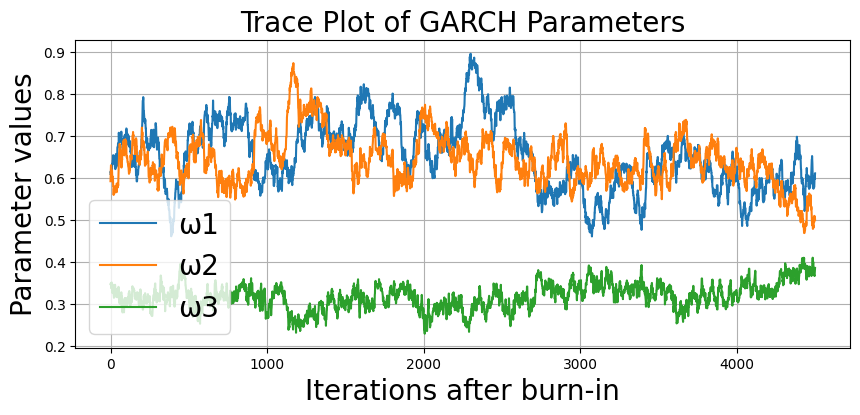

In [4]:
# Parameters
initial_omega = [0.3, 0.3, 0.3]
true_omega = [0.6, 0.7, 0.3]  # These are the true parameters we want to estimate
sigma_omega = [9, 9, 9]  # Standard deviations for the priors 

# Simulate data
returns, _ = simulate_garch(1000, *true_omega)

# Metropolis-Hastings settings
iterations = 5000
burn_in = 500
sigma_proposal = 0.01 

# Execute the Metropolis-Hastings algorithm
acceptance_rate, omega_samples = metropolis_hasting_algorithm(iterations, returns, sigma_proposal, initial_omega, sigma_omega)

# We extract the parameter samples
omega_samples = np.array(omega_samples)  # Convert list of samples into an array for easier slicing
w1_samples = omega_samples[:, 0]
w2_samples = omega_samples[:, 1]
w3_samples = omega_samples[:, 2]

# We plot the parameter trajectories
plt.figure(figsize=(10, 4))
plt.plot(w1_samples[burn_in:], label='ω1')
plt.plot(w2_samples[burn_in:], label='ω2')
plt.plot(w3_samples[burn_in:], label='ω3')
plt.legend(fontsize=20)
plt.xlabel('Iterations after burn-in', fontsize=20)
plt.ylabel('Parameter values', fontsize=20)
plt.title('Trace Plot of GARCH Parameters', fontsize=20)
plt.grid(True)
plt.show()

As previously discussed, we expect that 
$$\frac{1}{n}\sum_{i=1}^n f(X_i) \to \int f \, d\pi \quad \text{almost surely as } n \to \infty.$$ 
In this instance, we define the identity function as $f$: $f([\omega_1,\omega_2,\omega_3]) = [\omega_1,\omega_2,\omega_3]$. Consequently, we will verify whether the empirical means of these three sequences approach the actual values of the parameters $\omega_1$, $\omega_2$, and $\omega_3$.

In [5]:
# Computing the average values post burn-in
expected_w1 = np.average(w1_samples[burn_in:])
expected_w2 = np.average(w2_samples[burn_in:])
expected_w3 = np.average(w3_samples[burn_in:])

# Display the calculated mean values
print("Calculated Mean Values:")
print(f"Expected ω1: {expected_w1}")
print(f"Expected ω2: {expected_w2}")
print(f"Expected ω3: {expected_w3}")

Calculated Mean Values:
Expected ω1: 0.653192548458086
Expected ω2: 0.6431735604052816
Expected ω3: 0.3178397911342751


Our $\omega_1,\omega_2,\omega_3$ implemented in the garch_simulation were : $[0.6, 0.7, 0.3]$, therefore we have almost the same figures which means that our algorithm works well.

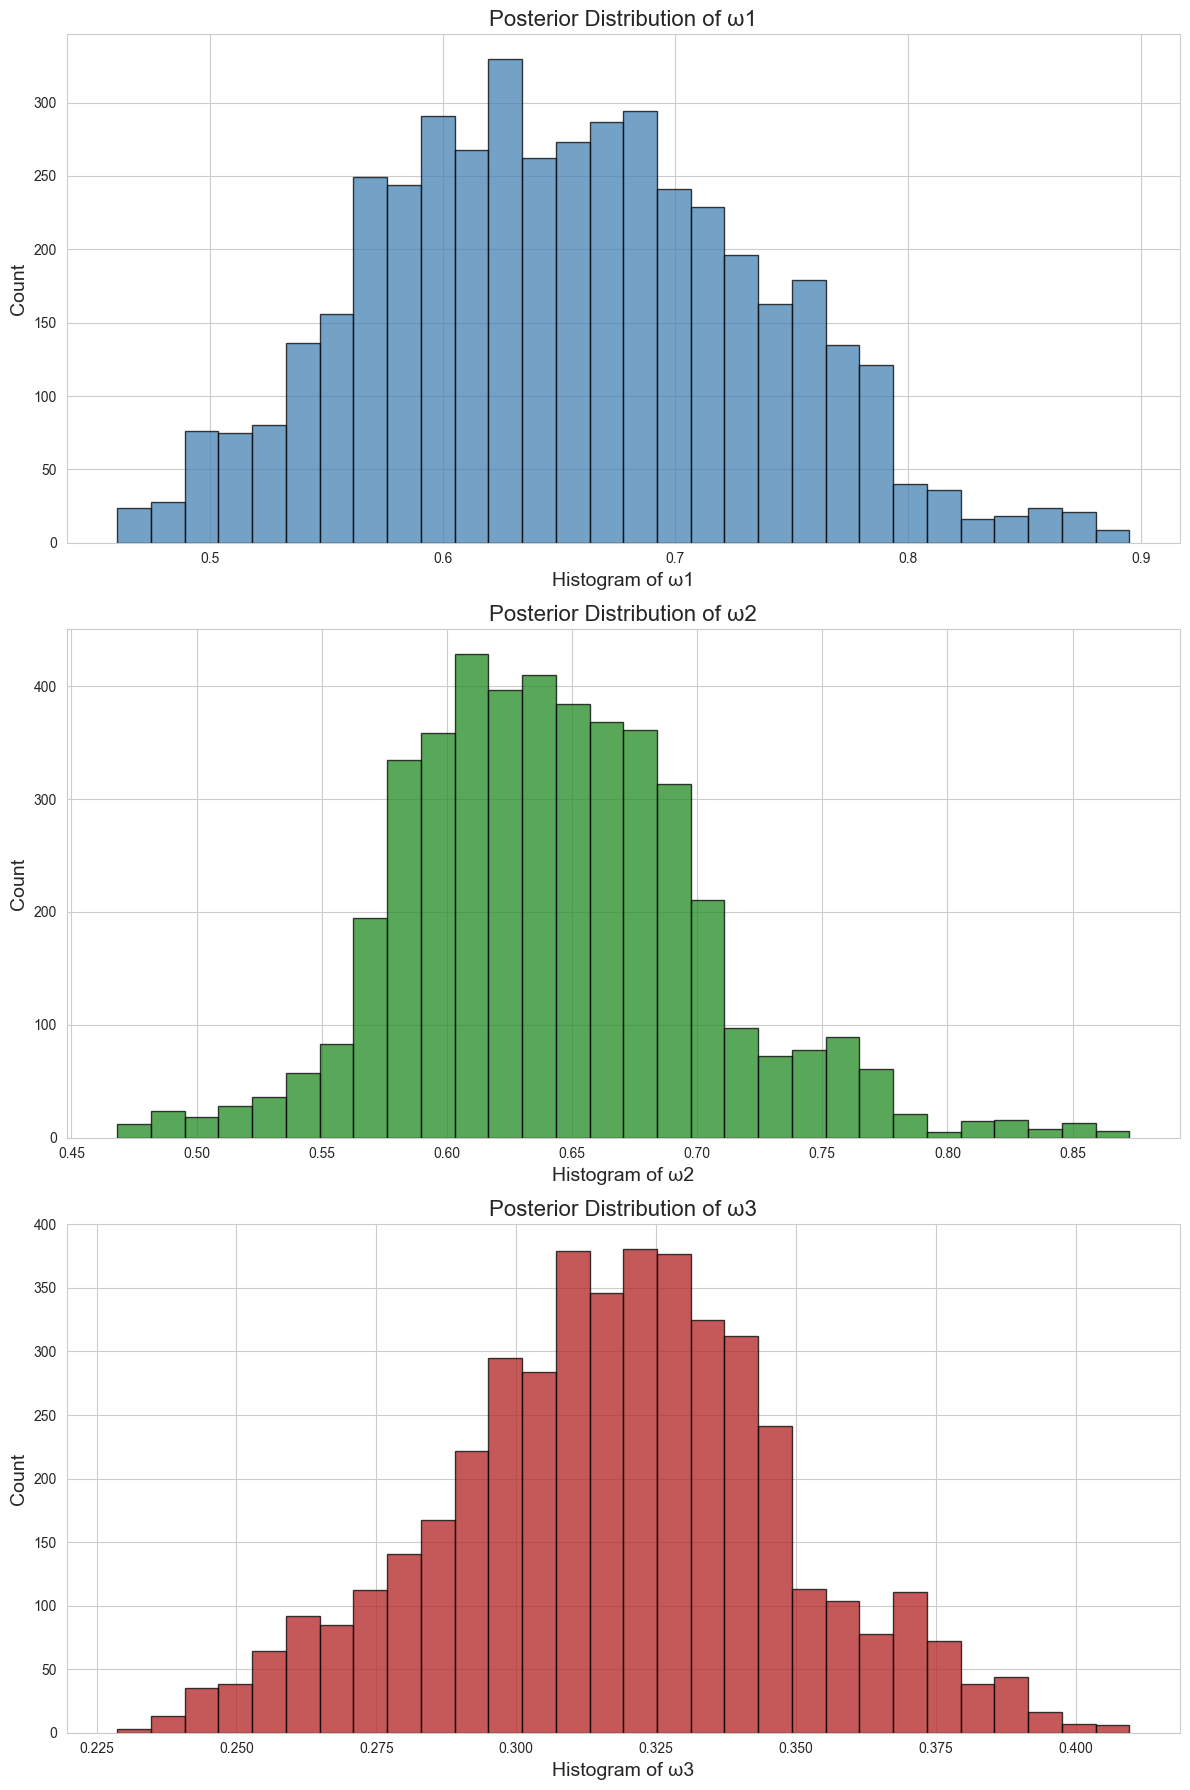

In [6]:
# Apply a seaborn style to enhance aesthetics
sns.set_style("whitegrid")

fig, axs = plt.subplots(3, figsize=(12, 18))

# Function to plot a histogram with matplotlib, with enhanced presentation
def custom_hist(data, bins, color, label, ax):
    counts, edges, _ = ax.hist(data, bins=bins, color=color, edgecolor='black', alpha=0.75)
    ax.set_xlabel(label, fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    return counts, edges

# Plot histograms with detailed customization
_, edges1 = custom_hist(w1_samples[burn_in:], 30, 'steelblue', 'Histogram of ω1', axs[0])
axs[0].set_title('Posterior Distribution of ω1', fontsize=16)

_, edges2 = custom_hist(w2_samples[burn_in:], 30, 'forestgreen', 'Histogram of ω2', axs[1])
axs[1].set_title('Posterior Distribution of ω2', fontsize=16)

_, edges3 = custom_hist(w3_samples[burn_in:], 30, 'firebrick', 'Histogram of ω3', axs[2])
axs[2].set_title('Posterior Distribution of ω3', fontsize=16)

# Fine-tuning the plot layout
plt.tight_layout()
plt.show()

We can see that these histograms of the posterior distribution of $\omega_1,\omega_2,\omega_3$ are almost histograms from normal distribution. However, they are not perfectly centered with the empirical expected value of omega but they are indeed near of them. We could also see it with boxplot.

We are now going to develop a function that will iterate the Metropolis-Hastings algorithm. This iterative approach is designed to facilitate statistical testing and study the distributions of the omega parameters. This function will play a crucial role in evaluating the robustness and statistical properties of our parameter estimates, providing insights into the effectiveness of the Metropolis-Hastings method in capturing the dynamics of financial time series.

In [7]:
def mean_metropolis_algorithm(iterations1):
    expected_w1_list = []
    expected_w2_list = []
    expected_w3_list = []
    for i in range(iterations1):
        results = metropolis_hasting_algorithm(iterations, returns, sigma_proposal, initial_omega, sigma_omega)

        # Check if results structure is as expected
        if not isinstance(results, tuple) or len(results) < 2:
            raise ValueError("The results from the Metropolis-Hasting algorithm do not match the expected format.")

        omega_samples = results[1]  # Assuming the second item is the list of omega samples

        # Prepare lists to hold the current iteration values for w1, w2, w3
        w1_samples = []
        w2_samples = []
        w3_samples = []

        # Extract samples depending on whether they are scalar or array-like
        for sample in omega_samples:
            w1_samples.append(sample[0])
            w2_samples.append(sample[1])
            w3_samples.append(sample[2])

        # Calculate means after burn-in period
        w1_expected = np.mean(w1_samples[burn_in:])
        w2_expected = np.mean(w2_samples[burn_in:])
        w3_expected = np.mean(w3_samples[burn_in:])
        
        expected_w1_list.append(w1_expected)
        expected_w2_list.append(w2_expected)
        expected_w3_list.append(w3_expected)
        
    return [expected_w1_list, expected_w2_list, expected_w3_list]

In [8]:
# Parameters
initial_omega = [0.3, 0.3, 0.3]
true_omega = [0.6, 0.7, 0.3]  # These are the true parameters we want to estimate
sigma_omega = [9, 9, 9]  # Standard deviations for the priors

# Simulate data
returns, _ = simulate_garch(900, *true_omega)

# Metropolis-Hastings settings
iterations = 3000 # less iterations than before
burn_in = 300 # smaller burn_in too
sigma_proposal = 0.01


In [9]:
mean_met_alg = mean_metropolis_algorithm(5)

As previously discussed, we are now set to evaluate whether the modified estimator function $\tilde{f}$ can successfully reduce the variance of our estimators without altering their expected values. By utilizing the outputs from the mean Metropolis algorithm, we will be able to measure the variance of our estimators and determine the efficacy of $\tilde{f}$ in achieving variance reduction. This analysis is crucial for enhancing the precision and reliability of our statistical estimations.

In [10]:
def variance_estimators(mean_met_alg):
    return statistics.variance(mean_met_alg[0]), statistics.variance(mean_met_alg[1]), statistics.variance(mean_met_alg[2])

So the variance without the method used in the article (we will see the vairance reduction in the next question) is:

In [11]:
print("The variance without the method used in the article is:")
print(f"Variance de ω1,w2,w3 : {variance_estimators(mean_met_alg)}")

The variance without the method used in the article is:
Variance de ω1,w2,w3 : (0.0008699321234375044, 0.0003502666052852463, 9.285919050176603e-05)


Now, let's check the unbiasedness of our estimators that has been proven in one of the article. We will see that there is still some bias but it is very small and it may be explicated by the few numbers of iterations of the metropolis_hasting_algorithm, so like it was said in the paper, there is the unbiasedness of the estimators.


In [12]:
def bias_estimators(mean_met_alg):
    return statistics.mean(mean_met_alg[0]) - true_omega[0], statistics.mean(mean_met_alg[1]) - true_omega[1], statistics.mean(mean_met_alg[2]) - true_omega[2]

print(f"The bias of the estimators are : {bias_estimators(mean_met_alg)}")

The bias of the estimators are : (0.10718685176151099, -0.04499540821504722, 0.007141588701138957)


To end this part we can finally check the mean squared error of the estimators:

In [13]:
mse = {}

# We calculate the MSE for each parameter
for i in range(1,4):
    mse[i] = statistics.mean([(omega - true_omega[i-1])**2 for omega in mean_met_alg[i-1]])

print(mse)

{1: 0.012184966889294126, 2: 0.002304800044666934, 3: 0.00012528964157764843}


### Real Data

We are transitioning from theoretical simulations to practical applications by testing our methods on real data. We focus on computing log-returns from exchange rates, specifically between the Euro and the GBP.

For this purpose, we retrieve data from the ECB (European Central Bank) database using the "DEXUSEU" series code, which represents the daily exchange rate between the US dollar and the Euro. This code allows us to directly query the relevant data for our analysis.


In [14]:
from lxml import etree
import requests
import pandas as pd

def fetch_ecb_data(series_id, start_date, end_date):
    # Define the URL template for accessing ECB data
    url = f"https://sdw-wsrest.ecb.europa.eu/service/data/EXR/D.{series_id}.EUR.SP00.A"

    # Set up headers to specify the desired response format as 'generic' XML
    headers = {
        'Accept': 'text/xml'
    }
    params = {
        'startPeriod': start_date,
        'endPeriod': end_date
    }
    response = requests.get(url, headers=headers, params=params)

    # We parse the XML response
    root = etree.fromstring(response.content)
    ns = {'ns': 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/message',
          'common': 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/common',
          'generic': 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/data/generic'}

    # Then we extract data points
    data = []
    for series in root.xpath('.//generic:Series', namespaces=ns):
        for obs in series.xpath('.//generic:Obs', namespaces=ns):
            time = obs.find('.//generic:ObsDimension', namespaces=ns).get('value')
            value = obs.find('.//generic:ObsValue', namespaces=ns).get('value')
            data.append({'Date': time, 'Rate': value})

    # Convert list of dictionaries into a DataFrame
    df = pd.DataFrame(data)
    df['Date'] = pd.to_datetime(df['Date'])
    df['rate'] = pd.to_numeric(df['Rate'], errors='coerce')
    return df

In [15]:
# We will use EUR to GBP exchanges rates on the year 2019 to 2022:
df = fetch_ecb_data('GBP', '2019-01-01', '2022-12-31')
df.head()

,Date,Rate,rate
0,2019-01-02,0.90165,0.90165
1,2019-01-03,0.90312,0.90312
2,2019-01-04,0.89988,0.89988
3,2019-01-07,0.8972,0.89720
4,2019-01-08,0.89743,0.89743


In [16]:
df["rate"] = (df["rate"] - df["rate"].shift(1)) / df["rate"].shift(1)
df = df.dropna()
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['rate'])
df['rate'] = df['rate'].interpolate() # for the missing values
rates = df["rate"].to_numpy()*100
rates

array([ 0.16303444, -0.35875631, -0.29781749, ..., -0.31132193,
        0.55758704,  0.16262183])

Following the methodology established in the first part of our study using simulated data, we now extend our analysis to real-world data. 
Before doing this, we fit a GARCH model to the exchange rate data retrieved in our previous step. This allows us to observe the model's behavior and effectiveness in capturing the financial time series' volatility characteristics under real market conditions.

In [17]:
import arch
real_garch = arch.arch_model(rates, vol = 'GARCH', p=1, q=1) # GARCH(1,1)
real_garch = real_garch.fit()
print(real_garch.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 468895.5390594251
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1630995142.1371253
Iteration:      3,   Func. Count:     23,   Neg. LLF: 662.8133416047322
Iteration:      4,   Func. Count:     30,   Neg. LLF: 664.4964495261827
Iteration:      5,   Func. Count:     36,   Neg. LLF: 613.0055477032379
Iteration:      6,   Func. Count:     41,   Neg. LLF: 613.003737194661
Iteration:      7,   Func. Count:     46,   Neg. LLF: 613.0008022334438
Iteration:      8,   Func. Count:     51,   Neg. LLF: 613.0007752881918
Iteration:      9,   Func. Count:     56,   Neg. LLF: 613.0007707085082
Iteration:     10,   Func. Count:     60,   Neg. LLF: 613.0007707085272
Optimization terminated successfully    (Exit mode 0)
            Current function value: 613.0007707085082
            Iterations: 10
            Function evaluations: 60
            Gradient evaluations: 10
                     Constant Mean - GARCH Model Results               

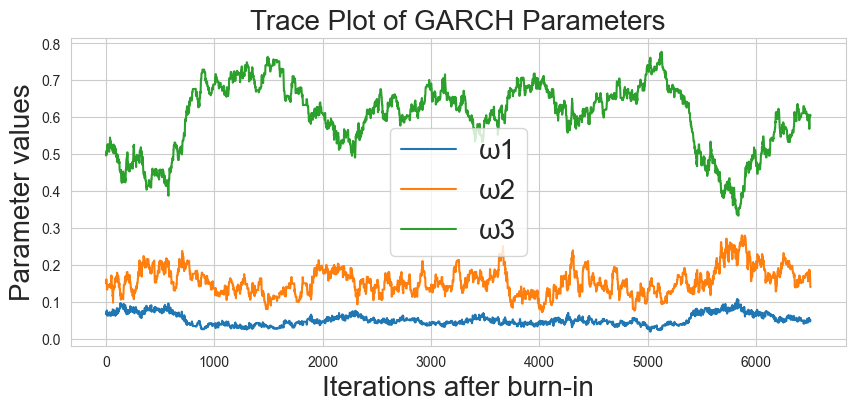

In [18]:
# Now we use our metropolis_hasting_algorithm with our real data, we use the same parameters as for the simulated data : ( the same thing as for simulated data)

# Parameters
initial_omega = [0.3, 0.3, 0.3]
true_omega = [0.0368,0.6921,0.1308] # These are the true parameters we want to estimate
sigma_omega = [9, 9, 9]  # Standard deviations for the priors

# Simulate data
returns = rates

# Metropolis-Hastings settings
iterations = 7000
burn_in = 500
sigma_proposal = 0.01

# Execute the Metropolis-Hastings algorithm
acceptance_rate, omega_samples = metropolis_hasting_algorithm(iterations, returns, sigma_proposal, initial_omega, sigma_omega)

# We extract the parameter samples
omega_samples = np.array(omega_samples)  # Convert list of samples into an array for easier slicing
w1_samples = omega_samples[:, 0]
w2_samples = omega_samples[:, 1]
w3_samples = omega_samples[:, 2]

# We plot the parameter trajectories
plt.figure(figsize=(10, 4))
plt.plot(w1_samples[burn_in:], label='ω1')
plt.plot(w2_samples[burn_in:], label='ω2')
plt.plot(w3_samples[burn_in:], label='ω3')
plt.legend(fontsize=20)
plt.xlabel('Iterations after burn-in', fontsize=20)
plt.ylabel('Parameter values', fontsize=20)
plt.title('Trace Plot of GARCH Parameters', fontsize=20)
plt.grid(True)
plt.show()


In [19]:
mean_met_alg2 = mean_metropolis_algorithm(5)

In [20]:
# Let's reuse the function we have implemented for the simulated datas :

# Variance
print(f"Variance de ω1,w2,w3 : {variance_estimators(mean_met_alg2)}")
# Bias
print(f"The bias of the estimators are : {bias_estimators(mean_met_alg2)}")
# MSE
mse = {}
for i in range(1,4):
    mse[i] = statistics.mean([(omega - true_omega[i-1])**2 for omega in mean_met_alg2[i-1]])
print(mse)


Variance de ω1,w2,w3 : (0.0007459593971068197, 0.0010028572745971488, 0.005601768095494535)
The bias of the estimators are : (-0.012311746399977175, -0.5571273940970953, 0.5348650937079967)
{1: 0.0007483466171028066, 2: 0.3111932190730978, 3: 0.2905620829436598}


We have very small variance, bias and mse as in with simulated datas !

In [21]:
# We can also check directly the mean of the estimators rather than the bias :

def mean_estimators(mean_met_alg2):
    return statistics.mean(mean_met_alg2[0]), statistics.mean(mean_met_alg2[1]), statistics.mean(mean_met_alg2[2])

print(f"The mean value of the estimators are : {mean_estimators(mean_met_alg2)}") # Recall : true_omega_1 = 0. , true_omega_2 = 0.4, true_omega_3 = 0.9

The mean value of the estimators are : (0.024488253600022825, 0.13497260590290475, 0.6656650937079968)


We can see that we have some very few difference between the expected empirical means and the true values. With real datas of EUR to GBP on 2019-2022, it works less than with our simulated datas.

## III - Use of Control Variates

*Consider the control variates proposed in the paper (Equation (8), and in particular the versions based on a first-order polynomial, i.e., $f(x) + a^T z$). Explain how you can use these control variates in this setting by doing a linear regression.*


The primary objective explored in this segment of the research paper is to minimize the variance of the estimators for the parameters $\omega_1$, $\omega_2$, and $\omega_3$. This is achieved by employing specific functions $H$ and $\psi$, which are used to construct the re-normalized function:

$$\tilde{f}(x) = f(x) + \frac{H\psi(x)}{\sqrt{\pi(x)}}$$

where $\pi$ denotes the posterior distribution function.

### Methodology

#### Hamiltonian and Trial Function
The Schrödinger-type Hamiltonian $H$, used in this context, is defined as:

\begin{equation}
    Hf = -2\Delta f + V(x)f
\end{equation}

The trial function $\psi(x)$ is set as $\psi(x) = P(x) * \pi(x)$, where $P$ is a polynomial. Given this setup, the re-normalized function $\tilde{f}(x)$ simplifies to:

$$\tilde{f}(x) = f(x) - \frac{1}{2} \Delta P(x) + \nabla P(x) \cdot z$$

Here, $z = -\frac{1}{2} \nabla \ln \pi(x)$ acts as the control variates, $\nabla$ is the gradient operator, and $\Delta = \sum_{i=1}^d\frac{\partial^2 }{\partial x_i^2}$ represents the Laplacian.

#### Application in a First Order Polynomial Case
For a first order polynomial $P(x) = \sum_{i=1}^3 a_i x_i$, the Laplacian $\Delta P(x)$ equals zero, simplifying our formula to:

$$\tilde{f}(x) = f(x) + a^T z$$

where $z$ is the vector of the three covariates.

### Estimation Strategy

#### Linear Regression for Variance Reduction
Our aim is to find a coefficient vector $a$ that minimizes the variance of $\tilde{f}(x)$. This is done through an ordinary least squares (OLS) regression of $f(x)$ on $-z$, which helps empirically determine:

$$\alpha = \arg\min_a \left(\sum_{i=1}^n (f(X_i) + a^T z_i)^2\right)$$

This effectively approximates the empirical expected value of $\tilde{f}(x)$, constructed to maintain the same expected value as $f(x)$, $\mu_f = \mu_{\tilde{f}}$.

#### Variance Analysis

$$V(\widetilde{f}) = V(f+a^Tz) = \mathbb{E}[(f+a^Tz)^2] - \mathbb{E}[(f+a^Tz)]^2 = \mathbb{E}[(f+a^Tz)^2] - \mathbb{E}[f]^2 \quad$$ 
The last equality comes from the fact that by construction $\mathbb{E}[\widetilde{f}] = \mathbb{E}[f] $.

We showed that $\mathbb{E}[f]^2$ does not depend by $a$. 
So minimizing $V(\widetilde{f})$ is equivalent to minimizing $\mathbb{E}[(f+a^Tz)^2] = \mathbb{E}[(f- a^T(-z))^2] $.  
We recognize the minimization problem of a linear regression of $f$ on $-z$ so we know that $a = \mathbb{E}[zz^T]^{-1}\mathbb{E}[zf]$ as the article says.

If $ \mathbb{E}[f^2]<∞$ and $\mathbb{E}[[ || -z || ]^2]<∞$ and $\mathbb{E}[zz^T]$ is a non singular matrix then the OLS estimator is consistent (if observations are IID). So we will estimate $a$ by $â$ the OLS estimator, given by:
$$â = (\sum_{t=1}^{T}z_tz_t^T)^{-1}(\sum_{t=1}^{T}-z_tf_t)$$



# Implementation

### Computation of the control variates

First of all, we need to compute the three control variates, defined by $z=-\frac{1}{2} \nabla \ln \pi$.

The gradient of the log-posterior $\ln \pi$ with respect to each parameter $ \omega_i $ involves contributions from the prior and the likelihood:
$$
\frac{\partial \ln \pi}{\partial \omega_i} = -\frac{\omega_i}{\sigma^2(\omega_i)} - \frac{1}{2} \sum_{t=1}^T \left( \frac{1}{h_t} \frac{\partial h_t}{\partial \omega_i} - \frac{r_t^2}{h_t^2} \frac{\partial h_t}{\partial \omega_i} \right), \quad i = 1, 2, 3
$$

The derivatives of the volatility equation $ h_t $ with respect to the parameters are defined as:
$$
\frac{\partial h_t}{\partial \omega_1} = \frac{1 - \omega_3^{t-1}}{1 - \omega_3} \quad \text{(assuming $ \omega_3 \neq 1 $)}
$$

$$
\frac{\partial h_t}{\partial \omega_2} = r_{t-1}^2 + \omega_3 \frac{\partial h_{t-1}}{\partial \omega_2} \quad \text{for } t > 1 \text{, and 0 else}
$$

$$
\frac{\partial h_t}{\partial \omega_3} = h_{t-1} + \omega_3 \frac{\partial h_{t-1}}{\partial \omega_3} \quad \text{for } t > 1 \text{, and 0 else}
$$


-------

**Error in the article ? Should be $\omega_3^t$ ?**

*Objective:*
Compute the derivative of $h_t= \omega_1 + \omega_2 r_{t-1}^2 + \omega_3 h_{t-1}$ with respect to $\omega_1$, $\frac{\partial h_t}{\partial \omega_1}$.

*Initial Setup:*
Since $\omega_1$ is a constant addition at each time step $t$,
$ \frac{\partial \omega_1}{\partial \omega_1} = 1 $
and since $r_{t-1}^2$ does not depend on $\omega_1$,
$ \frac{\partial (r_{t-1}^2)}{\partial \omega_1} = 0 $

*Recursive Derivation:*
Starting from the base case at $t=0$, assuming $h_0$ is either non-dependent on $\omega_1$ or set by an initial condition (making it a constant):
$ h_1 = \omega_1 + \omega_2 r_0^2 + \omega_3 h_0 $ gives 
$ \frac{\partial h_1}{\partial \omega_1} = 1 $

At $t=2$:
$ h_2 = \omega_1 + \omega_2 r_1^2 + \omega_3 h_1 $ gives
$ \frac{\partial h_2}{\partial \omega_1} = 1 + \omega_3 \cdot \frac{\partial h_1}{\partial \omega_1} = 1 + \omega_3 $

Proceeding recursively,
$ h_3 = \omega_1 + \omega_2 r_2^2 + \omega_3 h_2 $ gives 
$ \frac{\partial h_3}{\partial \omega_1} = 1 + \omega_3 \cdot \frac{\partial h_2}{\partial \omega_1} = 1 + \omega_3 + \omega_3^2 $

$$\vdots$$

$ \frac{\partial h_t}{\partial \omega_1} = 1 + \omega_3 + \omega_3^2 + \ldots + \omega_3^{t-1} $

Summation as a geometric series for $\omega_3 \neq 1$ yields:
$$ \frac{\partial h_t}{\partial \omega_1} = \frac{1 - \omega_3^t}{1 - \omega_3} $$


------

In [22]:
def compute_h_t_derivatives(r, omega_1, omega_2, omega_3):
    T = len(r)
    h = np.zeros(T)
    grad_h_omega1 = np.zeros(T)
    grad_h_omega2 = np.zeros(T)
    grad_h_omega3 = np.zeros(T)

    # Initial volatility
    h[0] = omega_1  

    # Compute h and its derivatives
    for t in range(1, T):
        h[t] = omega_1 + omega_2 * r[t-1]**2 + omega_3 * h[t-1]
        
        # Derivative of h_t with respect to omega_1
        grad_h_omega1[t] = (1 - omega_3**(t)) / (1 - omega_3) if omega_3 != 1 else t  # Using the geometric series

        # Derivative of h_t with respect to omega_2
        grad_h_omega2[t] = r[t-1]**2 + omega_3 * grad_h_omega2[t-1]

        # Derivative of h_t with respect to omega_3
        grad_h_omega3[t] = h[t-1] + omega_3 * grad_h_omega3[t-1]

    return h, grad_h_omega1, grad_h_omega2, grad_h_omega3

def compute_log_posterior_gradients(r, omega_1, omega_2, omega_3, sigma_1, sigma_2, sigma_3):
    h, grad_h_omega1, grad_h_omega2, grad_h_omega3 = compute_h_t_derivatives(r, omega_1, omega_2, omega_3)
    T = len(r)
    gradients = np.zeros(3)

    # Compute the gradient of the log-posterior for each parameter
    gradients[0] = -omega_1 / sigma_1**2 - 0.5 * np.sum((1 / h) * grad_h_omega1 - (r**2 / h**2) * grad_h_omega1)
    gradients[1] = -omega_2 / sigma_2**2 - 0.5 * np.sum((1 / h) * grad_h_omega2 - (r**2 / h**2) * grad_h_omega2)
    gradients[2] = -omega_3 / sigma_3**2 - 0.5 * np.sum((1 / h) * grad_h_omega3 - (r**2 / h**2) * grad_h_omega3)

    return gradients

def compute_log_posterior_gradients_concatenator(r, sigma_1, sigma_2, sigma_3,w1_samples,w2_samples,w3_samples):
    '''
    This function computes the log posterior gradients at every points
    '''
    gradient_concat=[]
    i = 0
    for _ in r:
        gradient_concat.append(compute_log_posterior_gradients(r, w1_samples[i],w2_samples[i],w3_samples[i], sigma_1, sigma_2, sigma_3))
        i = i +1 
    return np.array(gradient_concat)

def alternative_f(f,log_post_gradient):
    '''
    Calculates the value of the alternative function `f_tilde` 
    based on the observed values of the original function `f` and log-posterior 
    gradient `log_post_gradient`.

    Args:
        ????????? x (float): The point at which to evaluate the alternative function.
        f (ndarray): Vector containing observed values of the original function f.
        log_post_gradient (ndarray): The log-posterior gradient.

    Return:
        float: Vector of values of f_tilde 
    '''
    z = (-1/2) * log_post_gradient
    a = optimal_a(f,z)
    z = z.T
    return f.T + np.dot(a.T,z)

def optimal_a(f,z):
    '''
    Calculates the OLS estimator of the vector a

    Args : 
        f (ndarray): Vector containing observed values of the original function f.
        z (ndarray): Vector containing the values of the control variates.
        
    Return : OLS estimator of the vector a
    '''
    model = LinearRegression()
    model.fit(-z,f) #performs the linear regression of f on -z
    a = model.coef_
    return a


In [23]:
# Parameters
initial_omega = [0.3, 0.3, 0.3]
true_omega = [0.6, 0.7, 0.4]  # These are the true parameters we want to estimate
sigma_omega = [9, 9, 9]  # Standard deviations for the priors
T = 5000 + 1

# Simulate data
r, h = simulate_garch(T, true_omega[0], true_omega[1], true_omega[2])

# Metropolis-Hastings 
iterations = 5000
burn_in = 500
sigma_proposal = 0.01
acceptance_rate, omega_samples = metropolis_hasting_algorithm(iterations, r, sigma_proposal, initial_omega, sigma_omega)

# We extract the parameter samples
omega_samples = np.array(omega_samples)  # Convert list of samples into an array for easier slicing
w1_samples = omega_samples[:, 0]
w2_samples = omega_samples[:, 1]
w3_samples = omega_samples[:, 2]
w_samples=np.column_stack((w1_samples,w2_samples,w3_samples))

# We calculate the control variates (we handle the factor -1/2 in the alternative_f function)
log_post_gradient = compute_log_posterior_gradients_concatenator(r, sigma_omega[0], sigma_omega[1], sigma_omega[2],w1_samples,w2_samples,w3_samples)
log_post_gradient = np.column_stack((log_post_gradient[:,0],log_post_gradient[:,1],log_post_gradient[:,2]))

# We store our data in arrays after burn in 
w_samples_after_burn_in = np.array(w_samples[burn_in:])
log_post_gradient_after_burn_in = np.array(log_post_gradient[burn_in:])

In [24]:
print(f"L'estimation du vecteur w avec f, après burn-in, est {np.mean(w_samples_after_burn_in,axis=0)}")

w_alternative_after_burn_in = np.mean(alternative_f(w_samples_after_burn_in,log_post_gradient_after_burn_in).T,axis=0)
print(f"L'estimation du vecteur w avec f_tilde, après burn-in, est {w_alternative_after_burn_in}")

L'estimation du vecteur w avec f, après burn-in, est [0.69074959 0.59470012 0.39762461]
L'estimation du vecteur w avec f_tilde, après burn-in, est [0.60923897 0.67299788 0.3949891 ]


Now we will test this method.
As previously discussed, we expect that 
$$\frac{1}{n}\sum_{i=1}^n \widetilde{f}(X_i)  = \frac{1}{n}\sum_{i=1}^n (f(X_i) + a^Tz(X_i)) \to \int \widetilde{f}  \, d\pi \quad \text{almost surely as } n \to \infty.$$ 
$f$ is the same as in question 1: $f([\omega_1,\omega_2,\omega_3]) = [\omega_1,\omega_2,\omega_3]$. Consequently, we will verify whether the empirical means of these three sequences approach the actual values of the parameters $\omega_1$, $\omega_2$, and $\omega_3$ and if the variance is lower.

In [25]:
print("Expected value of w1 =", np.mean(w_samples_after_burn_in[0]))
print("Expected value of w1_tilde =", np.mean(w_alternative_after_burn_in[0]))
print("Variance of w1 =", np.var(w_samples_after_burn_in[0]))
print("Variance of w1_tilde =", np.var(w_alternative_after_burn_in[0])) 
print("\n")
print("Expected value of w2 =", np.mean(w_samples_after_burn_in[1]))
print("Expected value of w2_tilde =", np.mean(w_alternative_after_burn_in[1]))
print("Variance of w2 =", np.var(w_samples_after_burn_in[1]))
print("Variance of w2_tilde =", np.var(w_alternative_after_burn_in[1])) 
print("\n")
print("Expected value of w3 =", np.mean(w_samples_after_burn_in[2]))
print("Expected value of w3_tilde =", np.mean(w_alternative_after_burn_in[2]))
print("Variance of w3 =", np.var(w_samples_after_burn_in[2]))
print("Variance of w3_tilde =", np.var(w_alternative_after_burn_in[2])) 
print("\n")

Expected value of w1 = 0.5593869099016336
Expected value of w1_tilde = 0.6092389669724243
Variance of w1 = 0.0121184324446051
Variance of w1_tilde = 0.0


Expected value of w2 = 0.5593869099016336
Expected value of w2_tilde = 0.672997876481423
Variance of w2 = 0.0121184324446051
Variance of w2_tilde = 0.0


Expected value of w3 = 0.5637159393854673
Expected value of w3_tilde = 0.39498910208583965
Variance of w3 = 0.014057758808391491
Variance of w3_tilde = 0.0




On code deux petites fonctions pour comparer les résultats des deux méthodes MCMC et ZV MCMC.

In [30]:
def plot_comparision(w,w_alternative, name): 
    # We plot the different trajectories 
    plt.figure(figsize=(10,4))
    plt.plot(w)
    plt.plot(w_alternative)
    plt.legend(['MCMC','ZV MCMC'], fontsize=20)
    plt.xlabel('Itérations après burns in', fontsize=20)
    plt.title('Comparison of the trajectory of ' + name + ' between MCMC and ZV MCMC', fontsize=20)
    plt.ylabel('omega', fontsize=20)

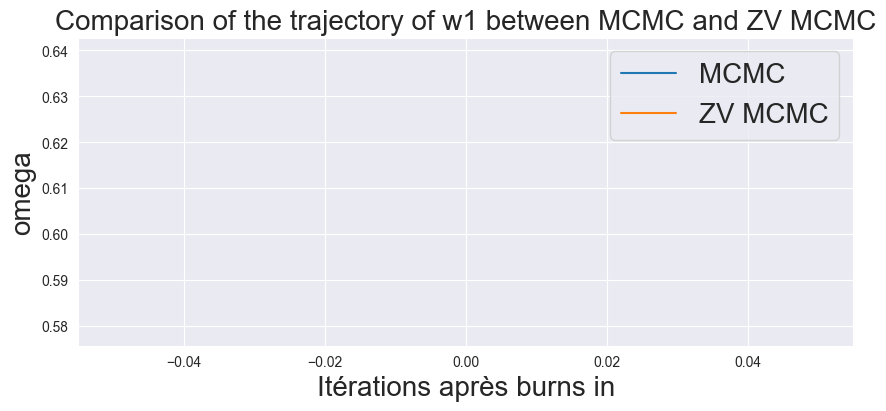

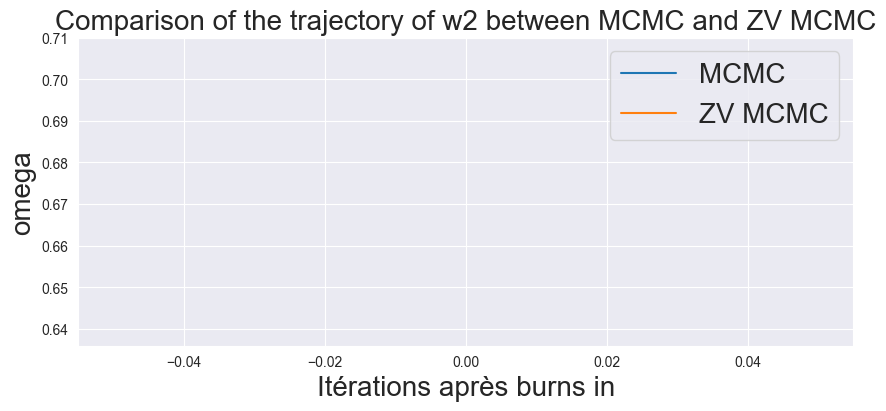

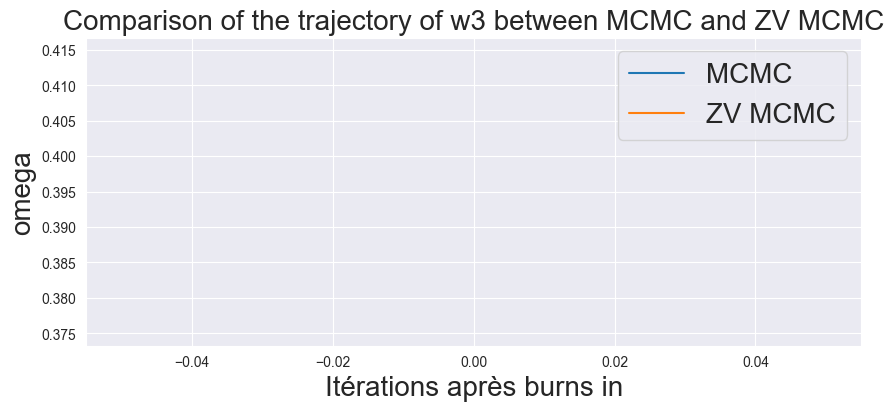

In [31]:
plot_comparision(w_alternative_after_burn_in[0], w_samples_after_burn_in[0][burn_in:],'w1')
plot_comparision(w_alternative_after_burn_in[1], w_samples_after_burn_in[1][burn_in:], 'w2')
plot_comparision(w_alternative_after_burn_in[2],w_samples_after_burn_in[2][burn_in:], 'w3')

In [32]:
def boxplot_comparision(w, w_alternative, name):
    sns.set_style('darkgrid')
    fig, ax = plt.subplots()
    ax.boxplot([w, w_alternative])
    ax.set_xticklabels(['MCMC', 'ZC-MCMC'])
    ax.set_title('Comparison of the boxplot for ' + name + ' between MCMC and ZV MCMC')
    plt.show()

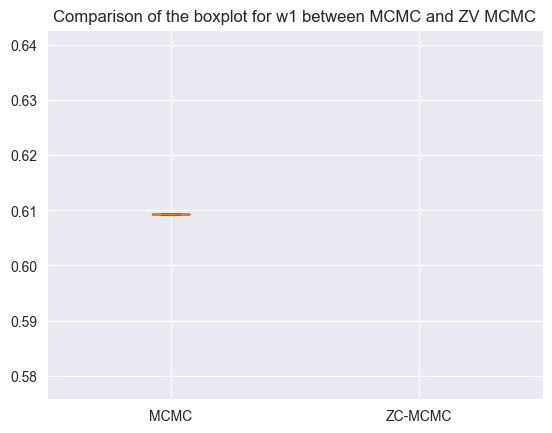

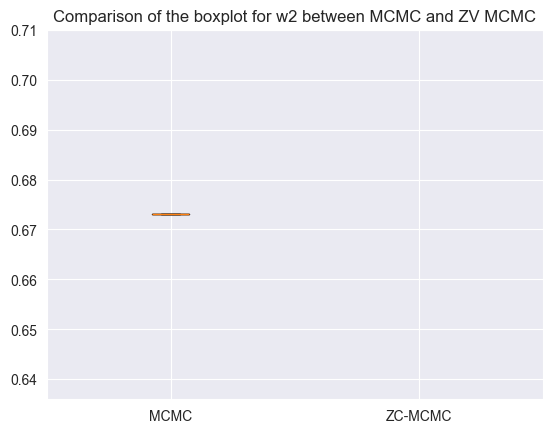

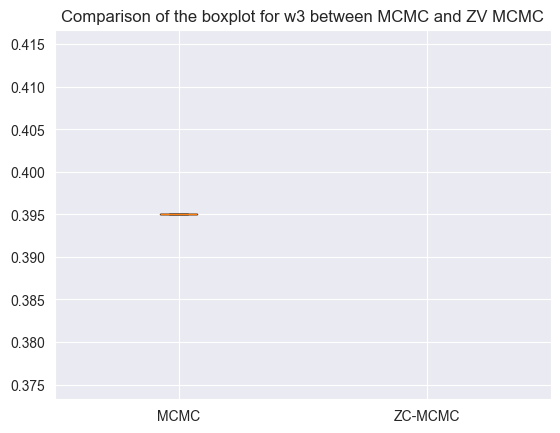

In [33]:
boxplot_comparision(w_alternative_after_burn_in[0], w_samples_after_burn_in[0][burn_in:],'w1')
boxplot_comparision(w_alternative_after_burn_in[1], w_samples_after_burn_in[1][burn_in:], 'w2')
boxplot_comparision(w_alternative_after_burn_in[2],w_samples_after_burn_in[2][burn_in:], 'w3')

We are now going to develop a function that will iterate the metropolis_hasting_algorithm in order to make statistical test and study on the distributions of the omega.


In [34]:
def mean_metropolis_algorithm_q2(iterations1):
    expected_w1_list = []
    expected_w2_list = []
    expected_w3_list = []
    for i in range(iterations1):
        results = metropolis_hasting_algorithm(iterations, returns, sigma_proposal, initial_omega, sigma_omega)

        # Check if results structure is as expected
        if not isinstance(results, tuple) or len(results) < 2:
            raise ValueError("The results from the Metropolis-Hasting algorithm do not match the expected format.")

        omega_samples = results[1]  # Assuming the second item is the list of omega samples

        # Prepare lists to hold the current iteration values for w1, w2, w3
        w1_samples = []
        w2_samples = []
        w3_samples = []

        # Extract samples depending on whether they are scalar or array-like
        for sample in omega_samples:
            if np.isscalar(sample):  # Handling cases where the sample might be a single scalar value
                w1_samples.append(sample)  # Assuming scalar results pertain to w1 or need clarification on which omega they relate to
            else:  # Otherwise, handle as arrays
                w1_samples.append(sample[0])
                w2_samples.append(sample[1])
                w3_samples.append(sample[2])

        # Calculate means after burn-in period
        w_samples = np.column_stack((w1_samples,w2_samples,w3_samples))
        w_expected = np.mean(alternative_f(w_samples[burn_in:],log_post_gradient[burn_in:]).T,axis=0)
        expected_w_mean = []
        expected_w_mean.append(w_expected)
        expected_w1_list.append(np.mean(alternative_f(w_samples[burn_in:],log_post_gradient[burn_in:])[0]))
        expected_w2_list.append(np.mean(alternative_f(w_samples[burn_in:],log_post_gradient[burn_in:])[1]))
        expected_w3_list.append(np.mean(alternative_f(w_samples[burn_in:],log_post_gradient[burn_in:])[2]))
    
    #return [expected_w1_list, expected_w2_list, expected_w3_list]
    return expected_w_mean, [expected_w1_list, expected_w2_list, expected_w3_list]

In [35]:
mean_met_alg2_q2 = mean_metropolis_algorithm_q2(5)[1]

# Variance
print(f"Variance de ω1,w2,w3 with f_tilde : {variance_estimators(mean_met_alg2_q2)}")
print(f"Variance de ω1,w2,w3 with f : {variance_estimators(mean_met_alg2)}")
print(f"Ratio des variances des w  pour f sur f_tilde : {variance_estimators(mean_met_alg2)[0]/variance_estimators(mean_met_alg2_q2)[0]}, {variance_estimators(mean_met_alg2)[1]/variance_estimators(mean_met_alg2_q2)[1]},{variance_estimators(mean_met_alg2)[2]/variance_estimators(mean_met_alg2_q2)[2]}") # grand ratio = bon fonctionnement

# Bias
print(f"The bias of the estimators are with f_tilde : {bias_estimators(mean_met_alg2_q2)}")
print(f"The bias of the estimators are with f: {bias_estimators(mean_met_alg2)}")
# MSE
mse = {}
for i in range(1,4):
    mse[i] = statistics.mean([(omega - true_omega[i-1])**2 for omega in mean_met_alg2_q2[i-1]])
print(mse)

Variance de ω1,w2,w3 with f_tilde : (0.060427436288664656, 0.011918298757808053, 0.0033882276035853208)
Variance de ω1,w2,w3 with f : (0.0007459593971068197, 0.0010028572745971488, 0.005601768095494535)
Ratio des variances des w  pour f sur f_tilde : 0.01234471364205056, 0.08414433091301268,1.6533033641444017
The bias of the estimators are with f_tilde : (-0.6711707135254965, -0.4473893163556875, 0.21030803294313216)
The bias of the estimators are with f: (-0.5755117463999772, -0.5650273940970952, 0.26566509370799674)
{1: 0.4988120757252558, 2: 0.20969183939545588, 3: 0.04694005080327781}


## IV - Expansion to Higher Order Polynomials

*Consider a larger set of control variates (by using a polynomial of order 2 for instance). When the number of control variates become too large, the linear regression approach of Step 2 may become too expensive (explain why). Adapt the method proposed in this paper: [https://doi.org/10.1007/s11222-021-10011-z](https://doi.org/10.1007/s11222-021-10011-z), which relies on the Lasso, to your problem, and compare with the naive approach (where you use only a single step based on a linear regression).*


## V - Bonus: Linear Regression Validity

*Is the fact that we do linear regression completely valid when applied to an MCMC sample? Try to think of ways to address this issue. Hint: you could think of ways to make MCMC simulations less "dependent", by sub-sampling, or averaging over blocks of a given size, or another approach.*